# MODELING AND PREDICT

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from src.plots import plot_coefficients_with_confidence_intervals

%matplotlib inline
import sys
sys.path.append('../../')

In [109]:
df = pd.read_csv("./data/raw/Breakfast At The Frat_dataset/cereal_Kellogg_Month.csv", index_col = 0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 35832 entries, 1331 to 169279
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   WEEK_END_DATE            35832 non-null  object 
 1   STORE_NUM                35832 non-null  float64
 2   UPC                      35832 non-null  int64  
 3   UNITS                    35832 non-null  float64
 4   VISITS                   35832 non-null  float64
 5   HHS                      35832 non-null  float64
 6   SPEND                    35832 non-null  float64
 7   PRICE                    35832 non-null  float64
 8   BASE_PRICE               35830 non-null  float64
 9   FEATURE                  35832 non-null  float64
 10  DISPLAY                  35832 non-null  float64
 11  TPR_ONLY                 35832 non-null  float64
 12  DESCRIPTION              35832 non-null  object 
 13  MANUFACTURER             35832 non-null  object 
 14  CATEGORY               

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,...,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS,MONTH,YEAR
1331,2009-01-14,367.0,3800031829,14.0,11.0,3.0,43.96,3.14,3.14,0.0,...,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051,1,2009
1332,2009-01-21,367.0,3800031829,17.0,13.0,6.0,53.38,3.14,3.14,0.0,...,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051,1,2009
1333,2009-01-28,367.0,3800031829,23.0,19.0,8.0,72.22,3.14,3.14,0.0,...,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051,1,2009
1334,2009-02-04,367.0,3800031829,25.0,23.0,10.0,78.50,3.14,3.14,0.0,...,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051,2,2009
1335,2009-02-11,367.0,3800031829,23.0,19.0,11.0,72.22,3.14,3.14,0.0,...,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051,2,2009


In [110]:
cat =  ["STORE_NUM", "UPC", "FEATURE", "DISPLAY", "TPR_ONLY", "MANUFACTURER", "CATEGORY", "SUB_CATEGORY", "STORE_ID", "STORE_NAME", "PRODUCT_SIZE","ADDRESS_CITY_NAME", "ADDRESS_STATE_PROV_CODE", "MSA_CODE", "SEG_VALUE_NAME", "MONTH", "YEAR"]
numeric = ["UNITS", "VISITS", "HHS", "SPEND", "PRICE", "BASE_PRICE", "PARKING_SPACE_QTY", "SALES_AREA_SIZE_NUM", "AVG_WEEKLY_BASKETS"]
medPSQ = df.PARKING_SPACE_QTY.median()
df.PARKING_SPACE_QTY.fillna(medPSQ,inplace=True)
df['WEEK_END_DATE'] = pd.to_datetime(df['WEEK_END_DATE'])
df[cat] = df[cat].astype("category")
df.groupby("SUB_CATEGORY", observed=False)[["BASE_PRICE", "PRICE", "UNITS"]].mean()

C:\Users\ACER\AppData\Local\Temp\ipykernel_20768\1437760153.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.PARKING_SPACE_QTY.fillna(medPSQ,inplace=True)


,BASE_PRICE,PRICE,UNITS
SUB_CATEGORY,,,
ALL FAMILY CEREAL,3.273618,3.164362,33.303007
KIDS CEREAL,3.094547,2.908529,42.817327


In [111]:
## Split dataset by 'SUB_CATEGOTY'

df_family = df[df.SUB_CATEGORY == 'ALL FAMILY CEREAL']
df_family_scaled = df_family.copy()
df_family_scaled[numeric] = (df_family_scaled[numeric] - df_family_scaled[numeric].mean()) / df_family_scaled[numeric].std()

df_kids = df[df.SUB_CATEGORY == 'KIDS CEREAL']
df_kids_scaled = df_kids.copy()
df_kids_scaled[numeric] = (df_kids_scaled[numeric] - df_kids_scaled[numeric].mean()) / df_kids_scaled[numeric].std()

print(df_family_scaled.shape)
print(df_kids_scaled.shape)

(11904, 28)
(23928, 28)


## REGRESSION MODEL FAMILY CEREAL 

In [112]:

Y_var = "UNITS"
X_var = ['PRICE', 'DISPLAY', 'FEATURE', 'ADDRESS_STATE_PROV_CODE', 'AVG_WEEKLY_BASKETS', 'SEG_VALUE_NAME', 'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM']

X = df_family_scaled[X_var].copy()
Y = df_family_scaled[Y_var]

X_train = X[df_family_scaled.WEEK_END_DATE <= '2010-12-31']
Y_train = df_family_scaled.loc[df_family_scaled.WEEK_END_DATE <= '2010-12-31', 'UNITS']
X_test = X[df_family_scaled.WEEK_END_DATE > '2010-12-31']
Y_test = df_family_scaled.loc[df_family_scaled.WEEK_END_DATE > '2010-12-31', 'UNITS']
reg = smf.ols(formula = 'UNITS ~ PRICE + DISPLAY + FEATURE + ADDRESS_STATE_PROV_CODE + AVG_WEEKLY_BASKETS + SEG_VALUE_NAME + PARKING_SPACE_QTY + SALES_AREA_SIZE_NUM', 
              data = df_family_scaled.query("WEEK_END_DATE <= '2010-12-31'"))
reg_model = reg.fit()
reg_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  UNITS   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     1090.
Date:                Mon, 24 Feb 2025   Prob (F-statistic):               0.00
Time:                        00:38:03   Log-Likelihood:                -7110.4
No. Observations:                7825   AIC:                         1.424e+04
Df Residuals:                    7813   BIC:                         1.433e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.3262      0.061      5.376      0.000       0.207       0.445
DISPLAY[T.1.0]                    1.2370      0.039     31.641      0.000       1.160       1.314
FEATURE[T.1.0]                    0.6211      0.025     25.311      0.000       0.573       0.669
ADDRESS_STATE_PROV_CODE[T.KY]     0.1951      0.068      2.855      0.004       0.061       0.329
ADDRESS_STATE_PROV_CODE[T.OH]    -0.1952      0.062     -3.169      0.002      -0.316      -0.074
ADDRESS_STATE_PROV_CODE[T.TX]    -0.8211      0.062    -13.300      0.000      -0.942      -0.700
SEG_VALUE_NAME[T.UPSCALE]         0.2402      0.019     12.802      0.000       0.203       0.277
SEG_VALUE_NAME[T.VALUE]          -0.2505      0.018    -13.812      0.000      -0.286      -0.215
PRICE                            -0.2528      0.010    -25.272      0.000      -0.272      -0.233
AVG_WEEKLY_BASKETS                0.1351      0.010     13.455      0.000       0.115       0.155
PARKING_SPACE_QTY                -0.0276      0.007     -3.743      0.000      -0.042      -0.013
SALES_AREA_SIZE_NUM               0.2366      0.012     20.489      0.000       0.214       0.259
==============================================================================
Omnibus:                     3029.073   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36682.224
Skew:                           1.510   Prob(JB):                         0.00
Kurtosis:                      13.168   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 1. **Tổng quan về mô hình:**
- **R-squared:** 0.605 – Mô hình giải thích 60.5% phương sai của biến phụ thuộc `UNITS`. Đây là mức độ phù hợp tương đối tốt.
- **Adj. R-squared:** 0.605 – Điều chỉnh cho số lượng biến giải thích, cho thấy kết quả ổn định.
- **F-statistic:** 1090 – Giá trị F cao và **Prob (F-statistic): 0.00**, chứng tỏ mô hình có ý nghĩa tổng thể.

---

### 3. **Những phát hiện chính:**
- **Trưng bày (DISPLAY)** và **tính năng nổi bật (FEATURE)** là các yếu tố quan trọng giúp tăng doanh số.
- **Giá cả (PRICE)** có tác động tiêu cực rõ rệt: Tăng giá làm giảm đáng kể số đơn vị bán.
- **Vị trí địa lý**: Các bang như Kentucky có tác động tích cực, trong khi Texas và Ohio có tác động tiêu cực.
- **Phân khúc khách hàng**: Khách hàng cao cấp mua nhiều hơn, trong khi phân khúc giá trị thấp ít mua hơn.
- **Số lượng chỗ đậu xe (PARKING_SPACE_QTY)** có tác động nhỏ nhưng ngược chiều.

---

### 4. **Kết luận:**
- Mô hình này cho thấy các yếu tố như **trưng bày**, **giá cả**, và **vị trí địa lý** có tác động mạnh đến doanh số bán hàng.
- Để tăng doanh số, nên tập trung vào **trưng bày sản phẩm**, **giảm giá một cách hợp lý**, và **nhắm vào phân khúc cao cấp**.
- Cần xem xét lại lý do vì sao **nhiều chỗ đậu xe** lại làm giảm doanh số, có thể do khách hàng không liên quan trực tiếp đến không gian bán lẻ.

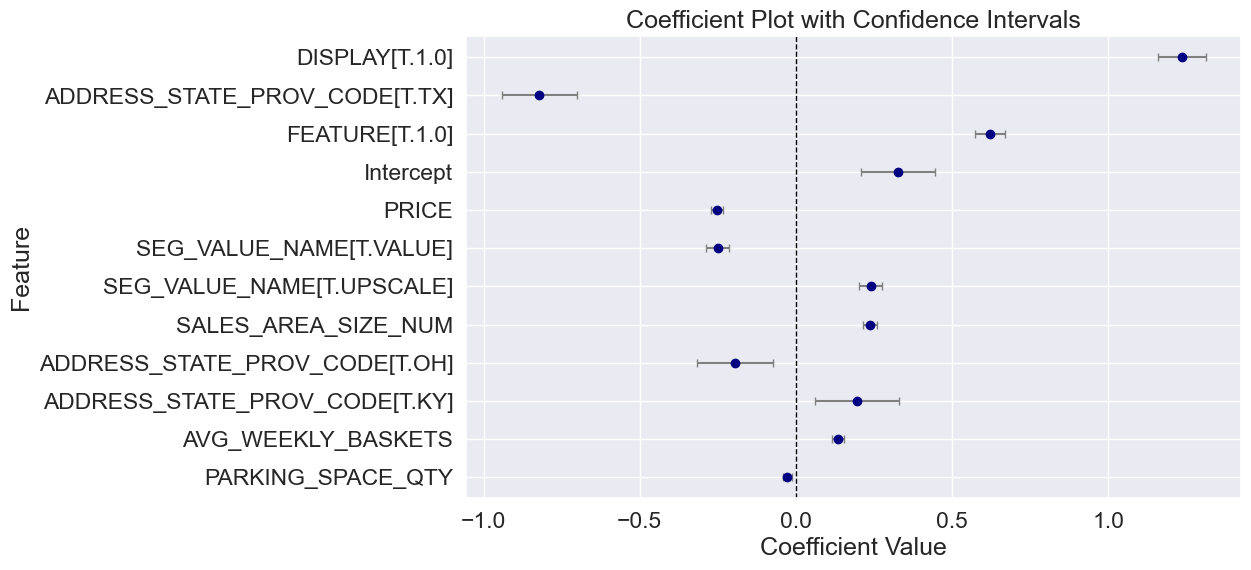

In [113]:


plot_coefficients_with_confidence_intervals(reg_model)

In [114]:
features = reg_model.params.index
coefficients = reg_model.params.values
conf = reg_model.conf_int()

# Tạo DataFrame từ các hệ số và khoảng tin cậy
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'CI Lower': conf[0],
    'CI Upper': conf[1]
})
coef_df

,Feature,Coefficient,CI Lower,CI Upper
Intercept,Intercept,0.326210,0.207260,0.445160
DISPLAY[T.1.0],DISPLAY[T.1.0],1.237040,1.160400,1.313679
FEATURE[T.1.0],FEATURE[T.1.0],0.621091,0.572989,0.669193
ADDRESS_STATE_PROV_CODE[T.KY],ADDRESS_STATE_PROV_CODE[T.KY],0.195117,0.061164,0.329070
ADDRESS_STATE_PROV_CODE[T.OH],ADDRESS_STATE_PROV_CODE[T.OH],-0.195246,-0.316016,-0.074476
ADDRESS_STATE_PROV_CODE[T.TX],ADDRESS_STATE_PROV_CODE[T.TX],-0.821054,-0.942068,-0.700039
SEG_VALUE_NAME[T.UPSCALE],SEG_VALUE_NAME[T.UPSCALE],0.240152,0.203379,0.276925
SEG_VALUE_NAME[T.VALUE],SEG_VALUE_NAME[T.VALUE],-0.250524,-0.286079,-0.214970
PRICE,PRICE,-0.252834,-0.272445,-0.233223
AVG_WEEKLY_BASKETS,AVG_WEEKLY_BASKETS,0.135133,0.115445,0.154820


**Tóm tắt ý chính:**

- **Ý nghĩa thống kê:** Tất cả các biến đều có ý nghĩa thống kê vì khoảng tin cậy không chứa số 0.
- **Ảnh hưởng tích cực đến doanh số:**  
  - Biến DISPLAY và FEATURE cho thấy nếu sản phẩm được trưng bày hoặc có tính năng nổi bật, doanh số bán tăng đáng kể.
  - Phân khúc UPSCALE, AVG_WEEKLY_BASKETS và SALES_AREA_SIZE_NUM đều tác động tăng doanh số.
- **Ảnh hưởng tiêu cực đến doanh số:**  
  - Giá (PRICE) tăng làm giảm số lượng bán.
  - Phân khúc VALUE cùng với các vị trí địa lý như Ohio và Texas có tác động tiêu cực đến doanh số.
  - Số lượng chỗ đậu xe (PARKING_SPACE_QTY) có tác động nhỏ nhưng giảm doanh số.

In [115]:
from src.stats import VIF
VIF(reg_model)

,feature,VIF,R-squared
0,Intercept,79.821081,0.605467
1,DISPLAY[T.1.0],1.151106,0.605467
2,FEATURE[T.1.0],1.457435,0.605467
3,ADDRESS_STATE_PROV_CODE[T.KY],5.037553,0.605467
4,ADDRESS_STATE_PROV_CODE[T.OH],19.665910,0.605467
5,ADDRESS_STATE_PROV_CODE[T.TX],20.527154,0.605467
6,SEG_VALUE_NAME[T.UPSCALE],1.193995,0.605467
7,SEG_VALUE_NAME[T.VALUE],1.301743,0.605467
8,PRICE,1.595643,0.605467
9,AVG_WEEKLY_BASKETS,2.178256,0.605467


- **Các biến có VIF thấp đến trung bình:**  
  - Các biến như `DISPLAY[T.1.0]`, `FEATURE[T.1.0]`, `SEG_VALUE_NAME[T.UPSCALE]`, `SEG_VALUE_NAME[T.VALUE]`, `PRICE`, `AVG_WEEKLY_BASKETS`, `PARKING_SPACE_QTY` và `SALES_AREA_SIZE_NUM` có VIF dưới 3, cho thấy mức độ đa cộng tuyến của chúng không đáng lo ngại.
  
- **Các biến có VIF cao:**  
  - Các biến `ADDRESS_STATE_PROV_CODE[T.KY]` có VIF khoảng 5.04, nhưng `ADDRESS_STATE_PROV_CODE[T.OH]` và `ADDRESS_STATE_PROV_CODE[T.TX]` có VIF lần lượt là 19.67 và 20.53, điều này cho thấy có mức độ tương quan cao giữa các biến liên quan đến địa chỉ bang, có thể gây ra vấn đề đa cộng tuyến trong mô hình.

Tóm lại, mô hình có hiệu quả trung bình với một số biến (đặc biệt là các biến về địa chỉ bang) có dấu hiệu đa cộng tuyến cao, cần được xem xét kỹ hơn trong quá trình cải thiện mô hình.

In [116]:
family_units_avg = df_family.UNITS.mean()
family_units_std = df_family.UNITS.std()
df_family_pred = df_family.copy()
df_family_scaled_pred = df_family_scaled.copy()
df_family_scaled_pred = df_family_scaled_pred.assign(pred_scaled = reg_model.predict(df_family_scaled_pred))
df_family_pred["pred"] = df_family_scaled_pred.pred_scaled * family_units_std + family_units_avg

test_pred = df_family_pred[df_family_pred.WEEK_END_DATE > '2010-12-31'].pred
y_test = df_family_pred[df_family_pred.WEEK_END_DATE > '2010-12-31'].UNITS

train_pred = df_family_pred[df_family_pred.WEEK_END_DATE <= '2010-12-31'].pred
y_train = df_family_pred[df_family_pred.WEEK_END_DATE <= '2010-12-31'].UNITS

print(np.sqrt(metrics.mean_squared_error(y_train, train_pred)))
print(np.sqrt(metrics.mean_squared_error(y_test, test_pred)))


16.79218431123609
20.52710153006466


In [117]:
from src.plots import plot_parabol

def calculate_pricing_results(df_family, df_family_scaled, reg_model, prices, COGS_rate,
                              display=None):
    """
    Tính toán tổng dự đoán về số lượng bán, doanh số và lợi nhuận cho các mức giá khác nhau.
    
    Parameters:
        df_family (DataFrame): DataFrame gốc chứa dữ liệu của các mặt hàng.
        df_family_scaled (DataFrame): DataFrame đã chuẩn hóa các biến.
        reg_model: Mô hình dự đoán.
        prices (iterable): Danh sách/array các mức giá cần tính.
        COGS_rate (float): Tỉ lệ chi phí giá vốn.
        family_units_std (float): Độ lệch chuẩn của số lượng bán.
        family_units_avg (float): Trung bình số lượng bán.
        price_avg (float): Giá trung bình.
        price_std (float): Độ lệch chuẩn của giá.
        display (int, optional): Nếu không None, đặt cột DISPLAY = display cho df_family_scaled.
        
    Returns:
        DataFrame chứa các cột: price, units, sales, profits.
    """
    price_avg = df_family.PRICE.mean()
    price_std = df_family.PRICE.std()
    family_units_avg = df_family.UNITS.mean()
    family_units_std = df_family.UNITS.std()
    cost = df_family.PRICE.mean() * COGS_rate
    results = {
        'price': [],
        'units': [],
        'sales': [],
        'profits': []
    }
    
    for p in prices:
        # Sao chép dữ liệu gốc và thay đổi giá
        df_family_pred = df_family.copy()
        df_family_pred["PRICE"] = p

        df_family_scaled_pred = df_family_scaled.copy()
        df_family_scaled_pred["PRICE"] = (p - price_avg) / price_std

        if display is not None:
            df_family_scaled_pred["DISPLAY"] = display

        # Tính dự đoán theo scale rồi chuyển về số lượng bán thực tế
        df_family_scaled_pred["pred_scaled"] = reg_model.predict(df_family_scaled_pred)
        df_family_pred["pred"] = df_family_scaled_pred["pred_scaled"] * family_units_std + family_units_avg

        # Tính tổng số lượng, doanh số và lợi nhuận
        units_sum = df_family_pred["pred"].sum()
        sales_sum = (df_family_pred["pred"] * df_family_pred["PRICE"]).sum()
        profit_sum = ((df_family_pred["PRICE"] - cost) * df_family_pred["pred"]).sum()

        results['price'].append(round(p, 1))
        results['units'].append(units_sum)
        results['sales'].append(sales_sum)
        results['profits'].append(profit_sum)
        
    return pd.DataFrame(results)

def get_optimal_price(df_result):
    max_profit_index = np.argmax(df_result["profits"])
    optimal_price = df_result.loc[max_profit_index, "price"]
    max_profit = df_result.loc[max_profit_index, "profits"]
    return optimal_price, max_profit


def print_pricing_summary(df_result, original_price, original_profits, set_price):
    """
    In ra bảng tóm tắt dự báo cho mức giá set_price.

    Parameters:
        df_result (DataFrame): DataFrame chứa kết quả dự báo.
        original_price (float): Giá trung bình ban đầu.
        original_profits (float): Tổng lợi nhuận ban đầu.
        set_price (float): Mức giá được chọn để đánh giá.
    """
    exp_profits = round(float(df_result[df_result.price == set_price].profits), 2)
    exp_units = int(df_result[df_result.price == set_price].units)
    exp_sales = round(float(df_result[df_result.price == set_price].sales), 2)
    
    print("Original average family cereal price:", original_price)
    print("Original sum of family cereal profits:", original_profits)
    print("Set price at", set_price)
    print("Expected Units:", exp_units)
    print("Expected Sales:", exp_sales)
    print("Expected Profits:", exp_profits)
    print("------------------------------")
    profit_increase = round(exp_profits - original_profits, 2)
    profit_pct = round((exp_profits - original_profits) / original_profits * 100, 2)
    print("Increased total profits by", profit_increase, ", which is a", profit_pct, "% increase")



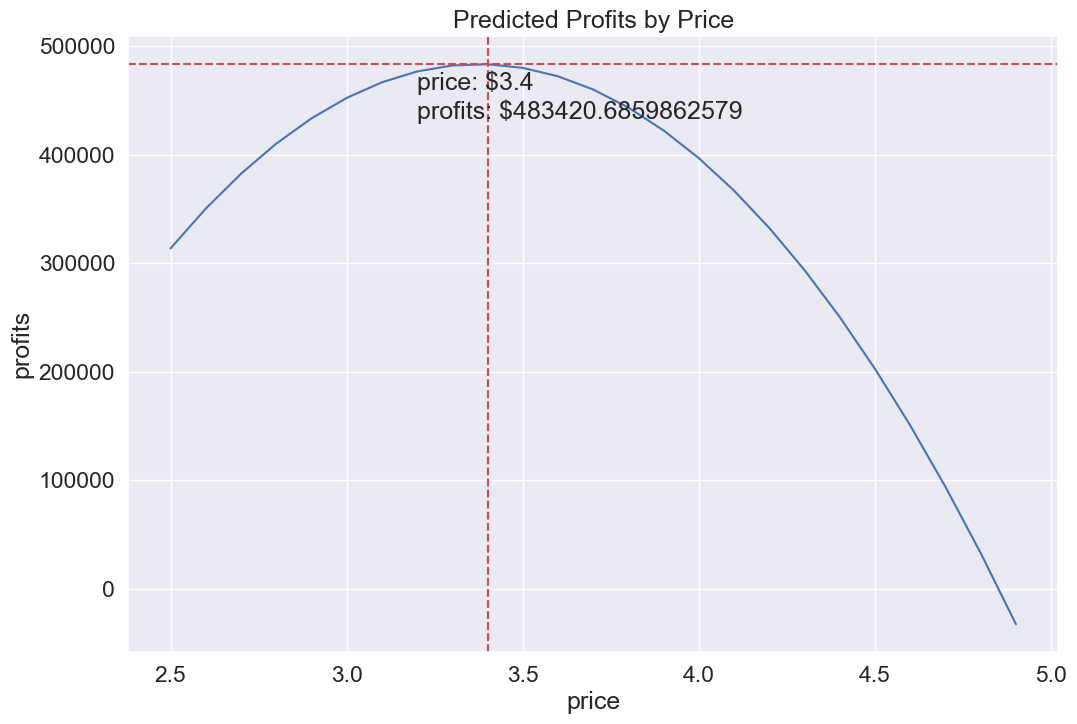

Original average family cereal price: 3.1643615591397847
Original sum of family cereal profits: 463596.4407137098
Set price at 3.4
Expected Units: 321983
Expected Sales: 1094744.15
Expected Profits: 483420.69
------------------------------
Increased total profits by 19824.25 , which is a 4.28 % increase


C:\Users\ACER\AppData\Local\Temp\ipykernel_20768\2032433008.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exp_profits = round(float(df_result[df_result.price == set_price].profits), 2)
C:\Users\ACER\AppData\Local\Temp\ipykernel_20768\2032433008.py:80: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  exp_units = int(df_result[df_result.price == set_price].units)
C:\Users\ACER\AppData\Local\Temp\ipykernel_20768\2032433008.py:81: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exp_sales = round(float(df_result[df_result.price == set_price].sales), 2)


In [118]:
# --- Scenario 1: COGS_rate = 0.6 ---
df_result = calculate_pricing_results(df_family, df_family_scaled, reg_model, prices=np.arange(2.5, 5, 0.1), COGS_rate = 0.6 )
optimal_price, max_profit = get_optimal_price(df_result)
plot_parabol(df_result,x_axis='price',y_axis="profits", x_point=optimal_price, y_point=max_profit)
original_profits = ((df_family.PRICE - df_family.PRICE.mean() * 0.6) * df_family.UNITS).sum()
print_pricing_summary(df_result, df_family.PRICE.mean(), original_profits, optimal_price)



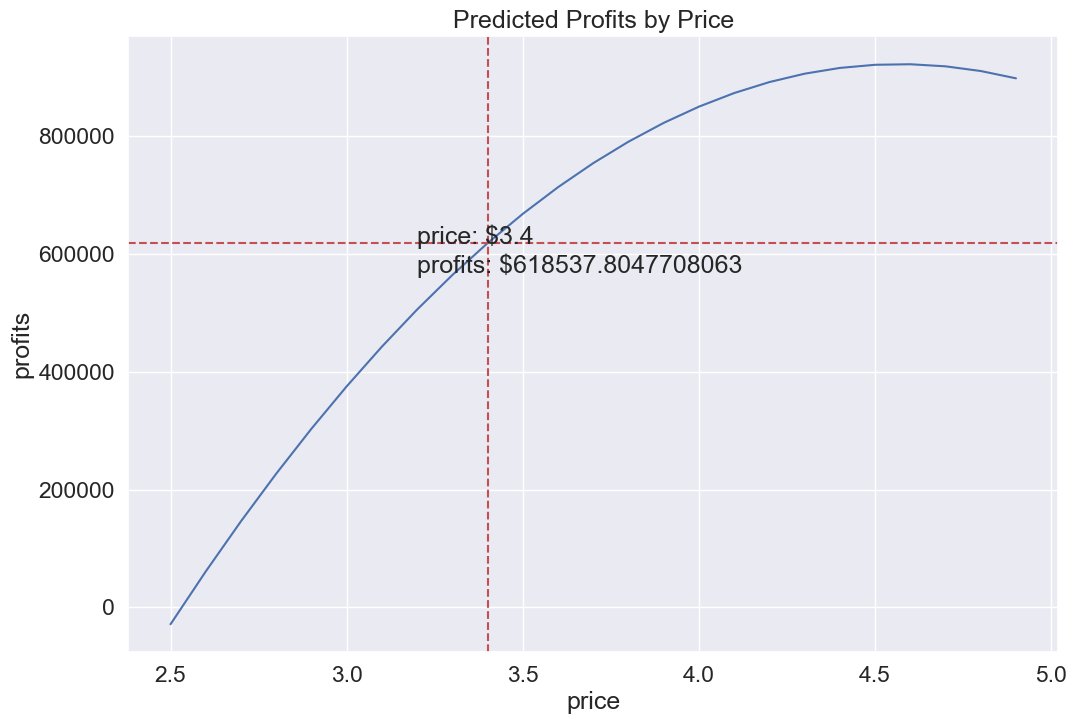

Original average family cereal price: 3.1643615591397847
Original sum of family cereal profits: 212701.1742849462
Set price at 3.4
Expected Units: 712182
Expected Sales: 2421419.11
Expected Profits: 618537.8
------------------------------
Increased total profits by 405836.63 , which is a 190.8 % increase


C:\Users\ACER\AppData\Local\Temp\ipykernel_20768\2032433008.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exp_profits = round(float(df_result[df_result.price == set_price].profits), 2)
C:\Users\ACER\AppData\Local\Temp\ipykernel_20768\2032433008.py:80: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  exp_units = int(df_result[df_result.price == set_price].units)
C:\Users\ACER\AppData\Local\Temp\ipykernel_20768\2032433008.py:81: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exp_sales = round(float(df_result[df_result.price == set_price].sales), 2)


In [119]:
# --- Scenario 2: COGS_rate = 0.8, với DISPLAY = 1 ---
df_result_display = calculate_pricing_results(df_family, df_family_scaled, reg_model, prices=np.arange(2.5, 5, 0.1), COGS_rate = 0.8, display=1)
# Vẽ đồ thị cho mức giá set_price
plot_parabol(df_result_display,x_axis='price',y_axis="profits", x_point=optimal_price, y_point=df_result_display[df_result_display['price'] == optimal_price]["profits"].values[0])
original_profits = ((df_family.PRICE - df_family.PRICE.mean() * 0.8) * df_family.UNITS).sum()
print_pricing_summary(df_result_display, df_family.PRICE.mean(), original_profits, optimal_price)


## Regression Model Kids Cereal


In [120]:
Y_var = "UNITS"
X_var = ['PRICE', 'DISPLAY', 'FEATURE', 'ADDRESS_STATE_PROV_CODE', 'AVG_WEEKLY_BASKETS', 'SEG_VALUE_NAME', 'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM']

X = df_kids_scaled[X_var].copy()
Y = df_kids_scaled[Y_var]

X_train = X[df_kids_scaled.WEEK_END_DATE <= '2010-12-31']
Y_train = df_kids_scaled.loc[df_kids_scaled.WEEK_END_DATE <= '2010-12-31', 'UNITS']
X_test = X[df_kids_scaled.WEEK_END_DATE > '2010-12-31']
Y_test = df_kids_scaled.loc[df_kids_scaled.WEEK_END_DATE > '2010-12-31', 'UNITS']
reg = smf.ols(formula = 'UNITS ~ PRICE + DISPLAY + FEATURE + ADDRESS_STATE_PROV_CODE + AVG_WEEKLY_BASKETS + SEG_VALUE_NAME + PARKING_SPACE_QTY + SALES_AREA_SIZE_NUM', 
              data = df_kids_scaled.query("WEEK_END_DATE <= '2010-12-31'"))
reg_model = reg.fit()
reg_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  UNITS   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     1671.
Date:                Mon, 24 Feb 2025   Prob (F-statistic):               0.00
Time:                        00:39:33   Log-Likelihood:                -15922.
No. Observations:               15773   AIC:                         3.187e+04
Df Residuals:                   15761   BIC:                         3.196e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.1219      0.048     -2.559      0.010      -0.215      -0.029
DISPLAY[T.1.0]                    0.5119      0.020     25.847      0.000       0.473       0.551
FEATURE[T.1.0]                    0.6938      0.021     33.022      0.000       0.653       0.735
ADDRESS_STATE_PROV_CODE[T.KY]     0.0741      0.053      1.388      0.165      -0.031       0.179
ADDRESS_STATE_PROV_CODE[T.OH]    -0.1226      0.048     -2.541      0.011      -0.217      -0.028
ADDRESS_STATE_PROV_CODE[T.TX]    -0.1961      0.048     -4.072      0.000      -0.291      -0.102
SEG_VALUE_NAME[T.UPSCALE]        -0.0976      0.015     -6.662      0.000      -0.126      -0.069
SEG_VALUE_NAME[T.VALUE]           0.1784      0.014     12.582      0.000       0.151       0.206
PRICE                            -0.3919      0.008    -50.733      0.000      -0.407      -0.377
AVG_WEEKLY_BASKETS                0.1758      0.008     22.475      0.000       0.160       0.191
PARKING_SPACE_QTY                -0.0433      0.006     -7.505      0.000      -0.055      -0.032
SALES_AREA_SIZE_NUM               0.0780      0.009      8.703      0.000       0.060       0.096
==============================================================================
Omnibus:                    16353.306   Durbin-Watson:                   1.358
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2362990.719
Skew:                           4.888   Prob(JB):                         0.00
Kurtosis:                      62.160   Cond. No.                         25.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""